In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = f"""
execution:
    exp_id: exp_034
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs
    cand_exp_dir: /kaggle/output/exp_033
    use_cand: True

feature:
    agg_freq: 12 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.4  # カラムが多い時は少なめ(0.4とか)にする。
    tree_method: "gpu_hist"
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
if CFG["dataset"]["use_cand"]:
    with open(os.path.join(CFG["dataset"]["cand_exp_dir"], "next_cands.pkl"), "rb") as f:
        next_cands = pickle.load(f)

## 特徴生成

In [4]:
def generate_features(train: pd.DataFrame):
    features = Features()

    # 時刻
    timestamp = pd.to_datetime(train["timestamp"].values[0])
    total_seconds = (timestamp - timestamp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    train["total_seconds"] = (total_seconds + train.index * 5) % (24 * 60 * 60) # [sec]
    train["minutes"] = train["total_seconds"] % (60 * 60)
    features.add_num_features(["total_seconds", "minutes"])    

    columns = ["anglez", "enmo"]

    # その人のその時刻での平均的な測定値
    gb = train.groupby("total_seconds")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["anglez_mean"] = train["total_seconds"].map(gb["anglez_mean"])
    train["enmo_mean"] = train["total_seconds"].map(gb["enmo_mean"])
    features.add_num_features(gb.columns.tolist())

    # diff
    f_names = [f"{c}_diff_abs" for c in columns]
    train[f_names] = train[columns].diff().abs()
    features.add_num_features(f_names)

    columns += f_names
    columns += gb.columns.tolist()

    # rolling
    dts = [10, 50, 100, 1000]
    shift_features_dic = {}
    for dt in dts:       
        shift_features = []

        f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).mean()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_std_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).std()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_max_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).max()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_min_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).min()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_median_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).median()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
        train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
        features.add_num_features(f_names)
        shift_features += f_names

        shift_features_dic[dt] = shift_features

    # 一定stepで集約
    series_id = train["series_id"].values[0]
    agg_freq = CFG["feature"]["agg_freq"]
    columns = features.all_features() + ["target", "step"]
    train = train[columns].groupby(train["step"].values // agg_freq).mean()
    train["series_id"] = series_id
    train["target"] = train["target"].round().astype(int)

    # shift
    for dt, shift_features in shift_features_dic.items():
        for c in [-5, -2, -1, -0.5, 0.5, 1, 2, 5]:
            c /= CFG["feature"]["agg_freq"]
            _dt = int(dt * c)
            if _dt == 0:
                continue
            f_names = [f"{c}_shift_{_dt}" for c in shift_features]
            train[f_names] = train[shift_features].shift(_dt)
            features.add_num_features(f_names)

    # next_candsにないstepは除外
    if CFG["dataset"]["use_cand"] and series_id in next_cands:
        cands = next_cands[series_id]
        train["reduce_step"] = train["step"].astype(int)
        train = train[train["reduce_step"].isin(cands)]

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

def read_and_generate_features(file):
    train = pd.read_csv(file)
    train, features = generate_features(train)
    return train, features

In [5]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.csv")

if CFG["execution"]["multiprocessing"]:
    with Pool(30) as pool:
        results = list(tqdm(pool.imap(read_and_generate_features, files), total=len(files)))
    dfs, features = zip(*results)
    train = pd.concat(dfs)
    features = features[0]

    del dfs, results
    gc.collect()
else:
    dfs = []
    for file in tqdm(files):
        train = pd.read_csv(file)
        train, features = generate_features(train)
        dfs.append(train)
    train = pd.concat(dfs)
    features = features[0]

100%|██████████| 277/277 [08:00<00:00,  1.74s/it]


## 学習

In [6]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train = train.merge(cv_split, on=["series_id"], how="left")
display(train.head(5))
train.shape

,anglez_diff_abs,anglez_diff_abs_rolling_max_10,anglez_diff_abs_rolling_max_100,anglez_diff_abs_rolling_max_1000,anglez_diff_abs_rolling_max_50,anglez_diff_abs_rolling_mean_10,anglez_diff_abs_rolling_mean_100,anglez_diff_abs_rolling_mean_1000,anglez_diff_abs_rolling_mean_50,anglez_diff_abs_rolling_median_10,...,anglez_mean_rolling_median_1000_shift_416,enmo_mean_rolling_median_1000_shift_416,anglez_rolling_square_mean_1000_shift_416,enmo_rolling_square_mean_1000_shift_416,anglez_diff_abs_rolling_square_mean_1000_shift_416,enmo_diff_abs_rolling_square_mean_1000_shift_416,anglez_mean_rolling_square_mean_1000_shift_416,enmo_mean_rolling_square_mean_1000_shift_416,reduce_step,fold
0,6.470050,19.959900,45.136975,84.6226,28.939600,7.135396,11.070924,8.455962,8.039186,5.145292,...,-23.415238,0.068863,1398.199985,0.006514,244.452555,0.003801,565.343713,0.006463,6761,3
1,4.170208,17.020700,51.115900,84.6226,37.729800,5.496785,11.148709,8.349434,9.465523,4.085612,...,-23.442641,0.068949,1426.281771,0.006511,242.545818,0.003800,568.277961,0.006716,6773,3
2,12.996533,31.041683,51.115900,84.6226,39.960817,11.343893,10.447975,8.239307,11.235963,8.627062,...,-23.489779,0.069069,1441.578655,0.006499,240.896660,0.003798,570.787095,0.007214,6785,3
3,18.041183,36.231917,51.115900,84.6226,51.115900,17.072160,10.843142,8.122251,12.620186,16.237775,...,-23.537860,0.069251,1462.867896,0.006490,238.500749,0.003796,573.990222,0.007815,6797,3
4,15.364133,39.897250,51.115900,84.6226,51.115900,14.853115,11.684691,7.964669,12.964835,12.276554,...,-23.607915,0.069651,1496.999579,0.006483,237.097778,0.003794,578.204445,0.008834,6809,3


(1483857, 1163)

In [7]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["xgboost"], 
    es_rounds=100
)
train["oof"] = trn_oof

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-logloss:0.64678
[50]	eval-logloss:0.29608
[100]	eval-logloss:0.28092
[150]	eval-logloss:0.27871
[200]	eval-logloss:0.27760
[250]	eval-logloss:0.28026
[300]	eval-logloss:0.28076
[303]	eval-logloss:0.28070


 20%|██        | 1/5 [00:57<03:50, 57.71s/it]

== fold 1 ==
[0]	eval-logloss:0.64655
[50]	eval-logloss:0.27475
[100]	eval-logloss:0.25573
[150]	eval-logloss:0.25071
[200]	eval-logloss:0.24803
[250]	eval-logloss:0.24508
[300]	eval-logloss:0.24524
[350]	eval-logloss:0.24566
[382]	eval-logloss:0.24561


 40%|████      | 2/5 [02:21<03:38, 72.96s/it]

== fold 2 ==
[0]	eval-logloss:0.64921
[50]	eval-logloss:0.29018
[100]	eval-logloss:0.27670
[150]	eval-logloss:0.27438
[200]	eval-logloss:0.27256
[250]	eval-logloss:0.27260
[300]	eval-logloss:0.27250
[303]	eval-logloss:0.27251


 60%|██████    | 3/5 [03:40<02:31, 75.94s/it]

== fold 3 ==
[0]	eval-logloss:0.65127
[50]	eval-logloss:0.31215
[100]	eval-logloss:0.29877
[150]	eval-logloss:0.30611
[200]	eval-logloss:0.31286
[213]	eval-logloss:0.31422


 80%|████████  | 4/5 [04:53<01:14, 74.48s/it]

== fold 4 ==
[0]	eval-logloss:0.65002
[50]	eval-logloss:0.31663
[100]	eval-logloss:0.30519
[150]	eval-logloss:0.30218
[200]	eval-logloss:0.30230
[250]	eval-logloss:0.30172
[300]	eval-logloss:0.30201
[316]	eval-logloss:0.30195


100%|██████████| 5/5 [06:37<00:00, 79.49s/it]


In [8]:
train = train.drop(columns=list(set(features.all_features()) - set(["minutes"])))
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)
train["STAGE"] = 2

In [9]:
train

,minutes,target,step,series_id,reduce_step,fold,oof,STAGE
0,3567.5,1,4673.5,038441c925bb,4673,2,0.997059,2
1,27.5,1,4685.5,038441c925bb,4685,2,0.997059,2
2,87.5,1,4697.5,038441c925bb,4697,2,0.998279,2
3,147.5,1,4709.5,038441c925bb,4709,2,0.992844,2
4,207.5,1,4721.5,038441c925bb,4721,2,0.993110,2
...,...,...,...,...,...,...,...,...
1483852,2847.5,1,592049.5,fe90110788d2,592049,2,0.998335,2
1483853,2907.5,1,592061.5,fe90110788d2,592061,2,0.997968,2
1483854,2967.5,1,592073.5,fe90110788d2,592073,2,0.997468,2
1483855,3027.5,1,592085.5,fe90110788d2,592085,2,0.997257,2


In [10]:
if CFG["dataset"]["use_cand"]:
    last_train = pd.read_csv(os.path.join(CFG["dataset"]["cand_exp_dir"], "oof.csv"))
    train = last_train.merge(train[["series_id", "oof", "STAGE", "step", "minutes"]], on=["series_id", "step"], how="left", suffixes=("_stage1", "_stage2"))
    train["oof"] = train["oof_stage2"].fillna(train["raw_oof"])
    train = train.sort_values(["series_id", "step"]).reset_index(drop=True)

## 予測値の作成

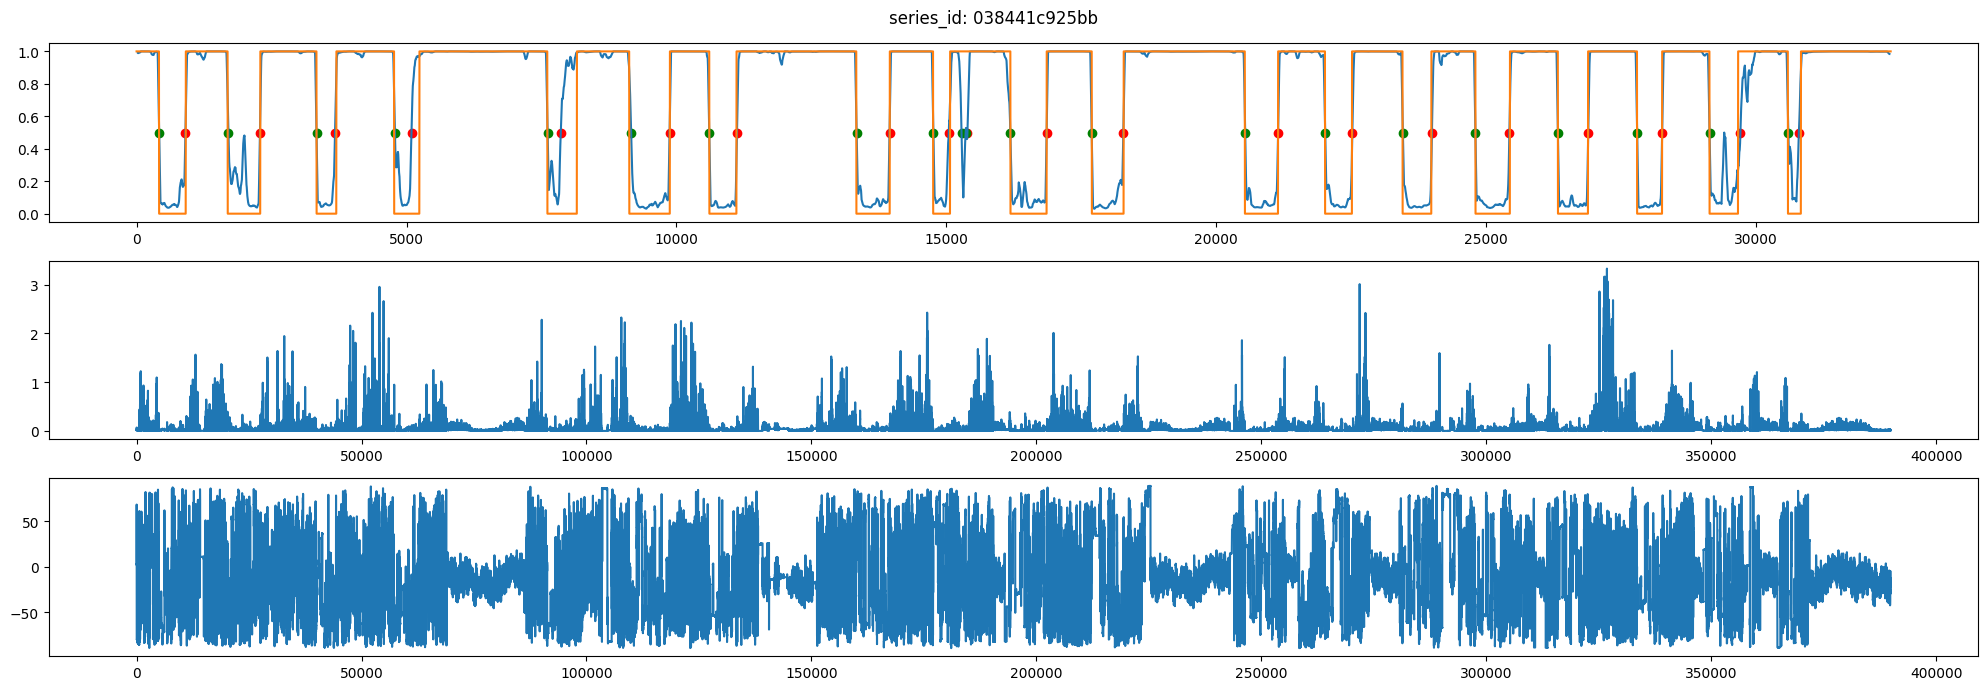

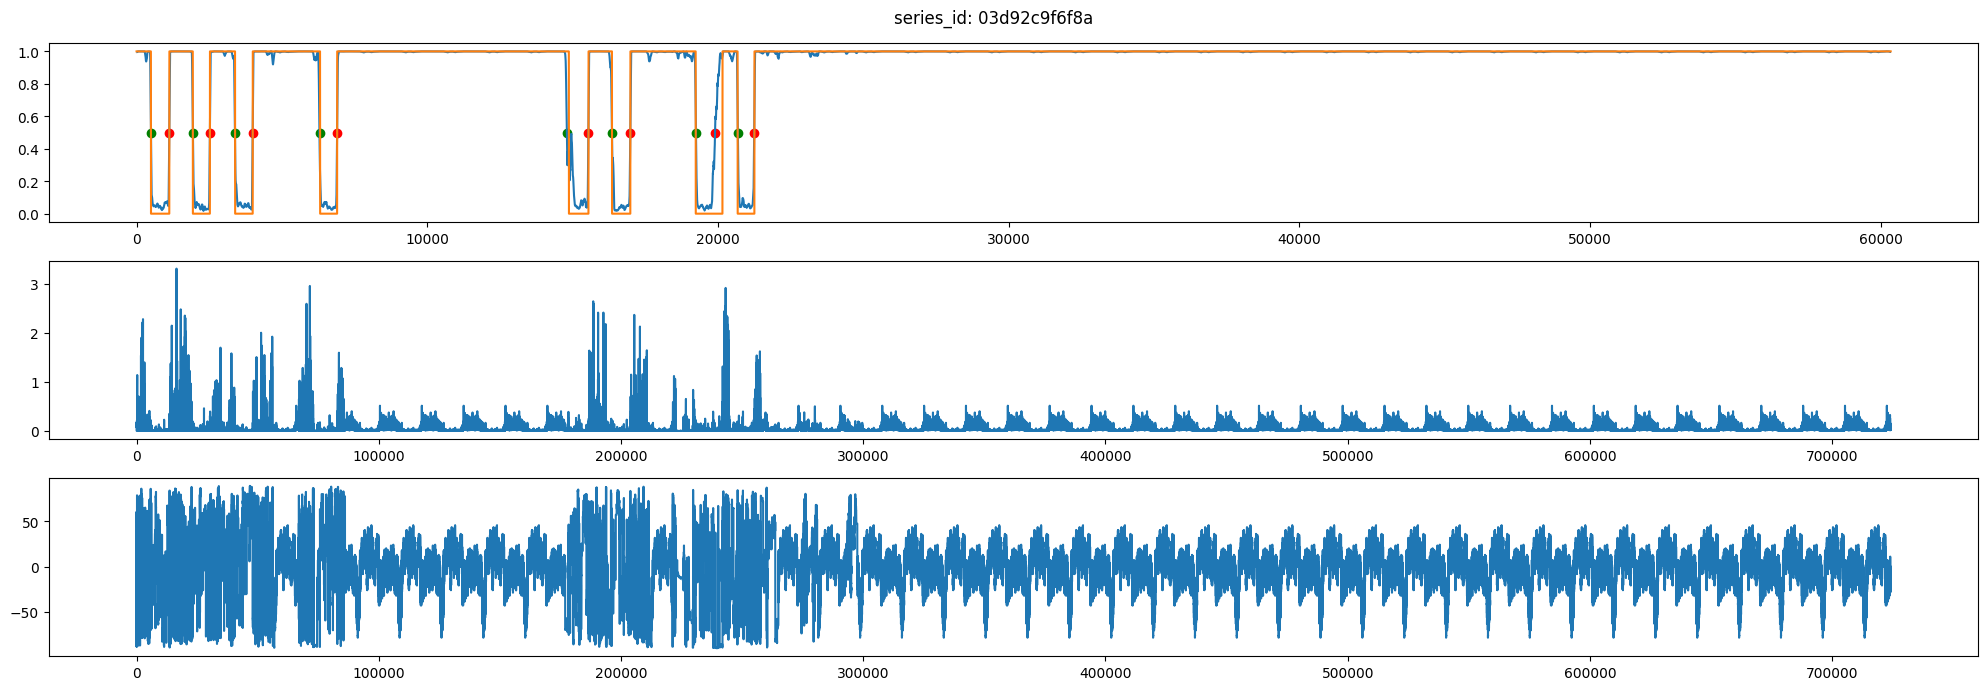

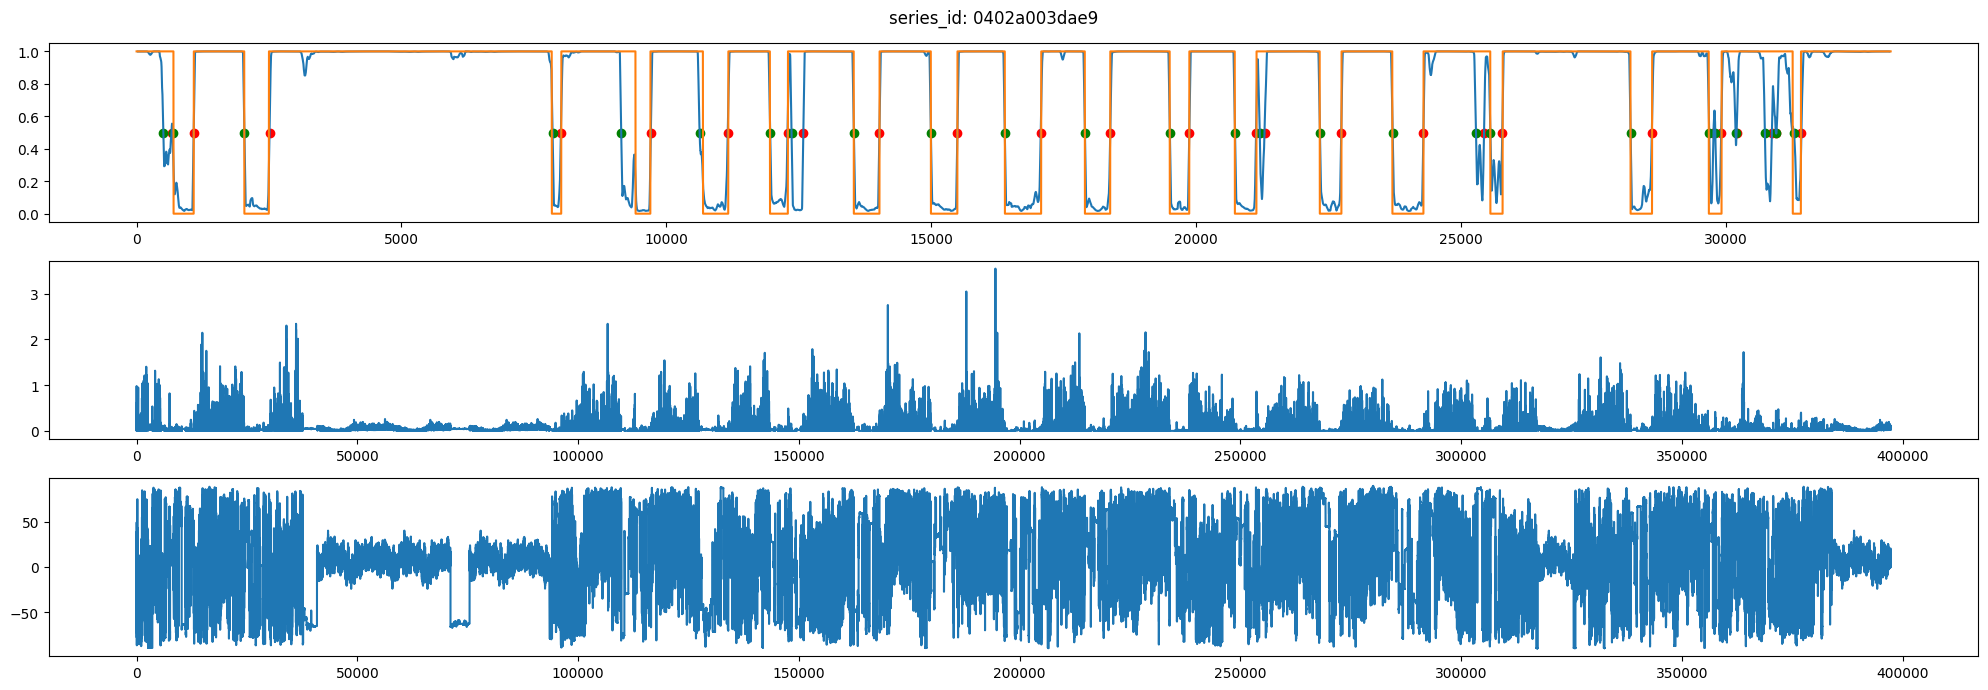

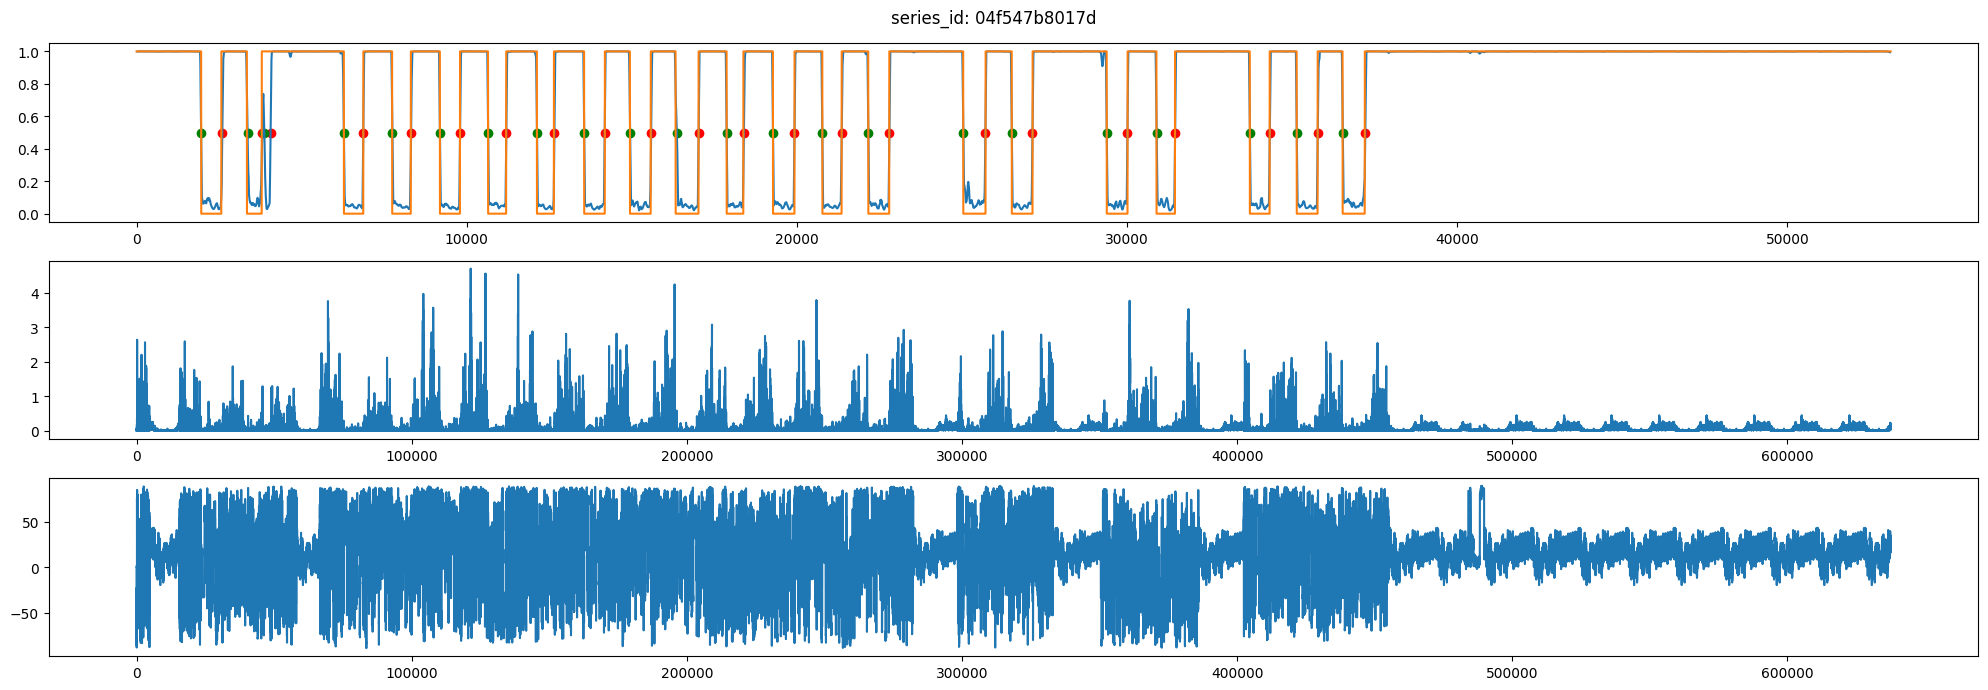

,series_id,step,event,score
0,038441c925bb,10859,wakeup,1
1,038441c925bb,27431,wakeup,1
2,038441c925bb,44111,wakeup,1
3,038441c925bb,61127,wakeup,1
4,038441c925bb,94307,wakeup,1


In [11]:
dfs = []
oofs = []
for series_id, df in train.groupby("series_id"):
    df = df.reset_index(drop=True)
    df["raw_oof"] = df["oof"]
    df["oof"] = df["oof"].rolling(48, center=True).mean()
    oofs.append(df)
    wakeup_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] < 0.5 and df["oof"][i] >= 0.5])
    onset_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] > 0.5 and df["oof"][i] <= 0.5])

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[wakeup_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "wakeup",
            "score": 1,
        }) if len(wakeup_index) > 0 else pd.DataFrame(),
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[onset_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "onset",
            "score": 1,
        }) if len(onset_index) > 0 else pd.DataFrame(),
    ])
    if len(sub) > 0:
        sub["step"] = sub["step"].astype(int)
        dfs.append(sub)

    if len(dfs) < 5:
        fig, axs = plt.subplots(3, 1, figsize=(20, 7))
        axs[0].plot(df["oof"])
        axs[0].plot(df["target"])
        axs[0].scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        axs[0].scatter(onset_index, [0.5 for _ in onset_index], c="green")
        df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{df['series_id'].values[0]}.csv")
        axs[1].plot(df["enmo"])
        axs[2].plot(df["anglez"])
        plt.suptitle(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()

train = pd.concat(oofs)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)
sub = pd.concat(dfs).reset_index(drop=True)
sub.head()

score: 0.4958


event   tolerance
onset   12           0.023555
        36           0.174216
        60           0.331297
        90           0.452208
        120          0.542183
        150          0.589173
        180          0.632477
        240          0.679906
        300          0.712036
        360          0.731066
wakeup  12           0.023721
        36           0.174763
        60           0.322108
        90           0.471682
        120          0.552889
        150          0.614709
        180          0.654454
        240          0.713249
        300          0.747496
        360          0.773536
dtype: float64

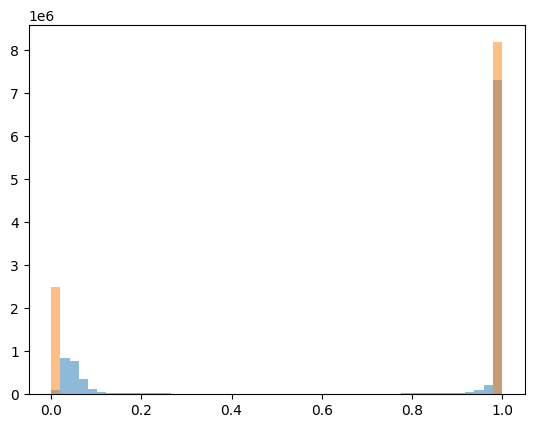

In [12]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()

In [13]:
# 次の候補の大きさ
next_cand_size = 0
count = 0
next_dict = {}
for series_id, train_df in train.groupby("series_id"):
    train_df = train_df[(train_df["oof"] >= 0.1) & (train_df["oof"] <= 0.9)]
    sub_df = sub[(sub["series_id"] == series_id)]
    label_df = labels[labels["series_id"] == series_id]
    pred_steps = train_df["step"].values
    sub_steps = sub_df["step"].values
    label_steps = label_df["step"].values

    if len(train_df) == 0:
        continue
    next_cand = np.zeros(int(max(max(pred_steps if len(pred_steps) > 0 else [0]), max(sub_steps if len(sub_steps) > 0 else [0]))) + CFG["feature"]["agg_freq"])
    for sub_step in sub_steps:
        next_cand[int(sub_step - CFG["feature"]["agg_freq"] * 5): int(sub_step + CFG["feature"]["agg_freq"] * 5)] = 1
    for pred_step in pred_steps:
        next_cand[int(pred_step - CFG["feature"]["agg_freq"] * 5): int(pred_step + CFG["feature"]["agg_freq"] * 5)] = 1
    next_cand_size += np.sum(next_cand)
    next_dict[series_id] = np.where(next_cand)[0]

    for label_step in label_steps:
        if label_step < next_cand.shape[0]:
            count += next_cand[int(label_step)]
    
recall = count / len(labels)
print(f"recall: {recall:.4f}")
print(f"next_cand_size: {next_cand_size}")

recall: 0.9552
next_cand_size: 10156368.0


In [14]:
import pickle

with open(f"{CFG['output_dir']}/next_cands.pkl", "wb") as f:
    pickle.dump(next_dict, f)